# Load candidates

In [1]:
%load_ext autoreload 
%autoreload 2
CACHE = '/home/anhphantq/vdb/cache_train_test'
import os

import pickle
from tqdm import tqdm
train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = metadata['num_frags']
max_session = metadata['max_session']

for i in tqdm(range(num_frags)):
    with open(CACHE + f'/test_train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      train_data.extend(data[0])
      num_cands.extend(data[1])






100%|██████████| 380/380 [00:06<00:00, 58.87it/s]


In [2]:
import numpy as np
train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((5158157, 39), (5158157,))

In [3]:
from xgb_utils import create_test_data

In [4]:
train_data.shape

(5158157, 39)

In [5]:
import pandas as pd 

candidates = create_test_data(train_data, infer = False, max_session=max_session)


In [6]:
del train_data

In [7]:
candidates  


,user,item,fiteness,user_clicks,user_carts,user_orders,user_num_sub,user_time_decay,user_lts,user_fts,...,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2
0,12695891.0,1461496.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,21.0,2.0,0.0,38.0,4.0,0.0,39.0,1.0,0.0
1,12695891.0,1722130.0,2.5,1.0,0.0,0.0,1.0,0.5,0.0,0.0,...,1.0,115.0,3.0,1.0,112.0,9.0,2.0,124.0,9.0,1.0
2,11277987.0,1463089.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,5.0,251.0,21.0,7.0,266.0,17.0,5.0,231.0,15.0,5.0
3,12403690.0,587552.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,2.0,13.0,8.0,4.0,8.0,2.0,1.0,5.0,4.0,0.0
4,12286180.0,1248842.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,208.0,6.0,2.0,115.0,4.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,11951362.0,1415257.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,14.0,0.0,0.0,18.0,0.0,0.0,14.0,0.0,0.0
5158153,11951362.0,283723.0,2.5,1.0,0.0,0.0,1.0,0.5,0.0,0.0,...,3.0,81.0,8.0,4.0,88.0,7.0,3.0,97.0,11.0,3.0
5158154,12733786.0,433636.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,126.0,5.0,1.0,168.0,3.0,0.0,196.0,5.0,2.0
5158155,11825189.0,778424.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,21.0,1.0,0.0,18.0,0.0,0.0,18.0,1.0,1.0


In [8]:
len(candidates.columns)

39

# Train params

In [9]:
PARAMS = {
    'max_depth' : 5,
    'eta': 0.5,    
    'min_child_weight': 1000,
}
N_SPLITS = 3
NUM_TREE = 100
MODEL_PATH = '/home/anhphantq/xgboost_test'
VERSION = '4'

# Train for each type

In [10]:
from xgb_utils import get_len_group

In [11]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1

In [12]:
tar

,user,type,item,label
113400,11188590,0,607328,1
113401,11188591,0,557157,1
113402,11188591,1,1597320,1
113402,11188591,1,1236555,1
113402,11188591,1,970284,1
...,...,...,...,...
2212687,12899774,0,1399483,1
2212688,12899775,0,1760714,1
2212689,12899776,0,1737908,1
2212690,12899777,0,384045,1


In [13]:
candidates

,user,item,fiteness,user_clicks,user_carts,user_orders,user_num_sub,user_time_decay,user_lts,user_fts,...,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2
0,12695891.0,1461496.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,21.0,2.0,0.0,38.0,4.0,0.0,39.0,1.0,0.0
1,12695891.0,1722130.0,2.5,1.0,0.0,0.0,1.0,0.5,0.0,0.0,...,1.0,115.0,3.0,1.0,112.0,9.0,2.0,124.0,9.0,1.0
2,11277987.0,1463089.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,5.0,251.0,21.0,7.0,266.0,17.0,5.0,231.0,15.0,5.0
3,12403690.0,587552.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,2.0,13.0,8.0,4.0,8.0,2.0,1.0,5.0,4.0,0.0
4,12286180.0,1248842.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,208.0,6.0,2.0,115.0,4.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,11951362.0,1415257.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,14.0,0.0,0.0,18.0,0.0,0.0,14.0,0.0,0.0
5158153,11951362.0,283723.0,2.5,1.0,0.0,0.0,1.0,0.5,0.0,0.0,...,3.0,81.0,8.0,4.0,88.0,7.0,3.0,97.0,11.0,3.0
5158154,12733786.0,433636.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,126.0,5.0,1.0,168.0,3.0,0.0,196.0,5.0,2.0
5158155,11825189.0,778424.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,21.0,1.0,0.0,18.0,0.0,0.0,18.0,1.0,1.0


In [14]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
import shutil
import matplotlib.pyplot as plt
def train(tar_, candidates_, t, num_cands, id_type):
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove old version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  candidates = candidates_.copy()
  candidates['type'] = id_type
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)

  # neg_idx = np.argwhere(candidates['label'].values.flatten() == 0)
  # neg_idx = np.random.permutation(neg_idx)[: int(len(neg_idx) * 0.5)]
  # candidates = candidates.drop(neg_idx.flatten()).reset_index()
  # num_cands = candidates[['user', 'item']].groupby('user').count().reset_index()
  # num_cands['num_cands'] = num_cands['item']
  # del num_cands['item'] 
  # candidates = candidates.merge(num_cands,on=['user'],how='left')
  # num_cands = candidates['num_cands'].values


  print(np.sum(candidates['label']), candidates.shape[0])
  
  del candidates['type'], candidates['user_type']

  skf = GroupKFold(n_splits=N_SPLITS)
  fig, axs = plt.subplots(1,3, figsize = (30, 10))
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -1]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -1]
      y_valid = candidates.iloc[valid_idx, -1]

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count() ) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count() ) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = {'objective':'rank:pairwise', 'nthread' : os.cpu_count(),
      **PARAMS}
      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          verbose_eval=1,
          early_stopping_rounds= 5, )
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model, ax = axs[fold], max_num_features= 30)

540517 5158157
[0]	train-map:0.95406	valid-map:0.95396
[1]	train-map:0.95405	valid-map:0.95400
[2]	train-map:0.95454	valid-map:0.95455
[3]	train-map:0.95451	valid-map:0.95446
[4]	train-map:0.95508	valid-map:0.95499
[5]	train-map:0.95516	valid-map:0.95511
[6]	train-map:0.95543	valid-map:0.95532
[7]	train-map:0.95562	valid-map:0.95544
[8]	train-map:0.95573	valid-map:0.95552
[9]	train-map:0.95590	valid-map:0.95574
[10]	train-map:0.95614	valid-map:0.95604
[11]	train-map:0.95624	valid-map:0.95617
[12]	train-map:0.95630	valid-map:0.95618
[13]	train-map:0.95635	valid-map:0.95620
[14]	train-map:0.95652	valid-map:0.95636
[15]	train-map:0.95659	valid-map:0.95645
[16]	train-map:0.95661	valid-map:0.95644
[17]	train-map:0.95664	valid-map:0.95645
[18]	train-map:0.95663	valid-map:0.95644
[19]	train-map:0.95665	valid-map:0.95647
[20]	train-map:0.95666	valid-map:0.95648
[21]	train-map:0.95671	valid-map:0.95654
[22]	train-map:0.95682	valid-map:0.95660
[23]	train-map:0.95683	valid-map:0.95661
[24]	train-

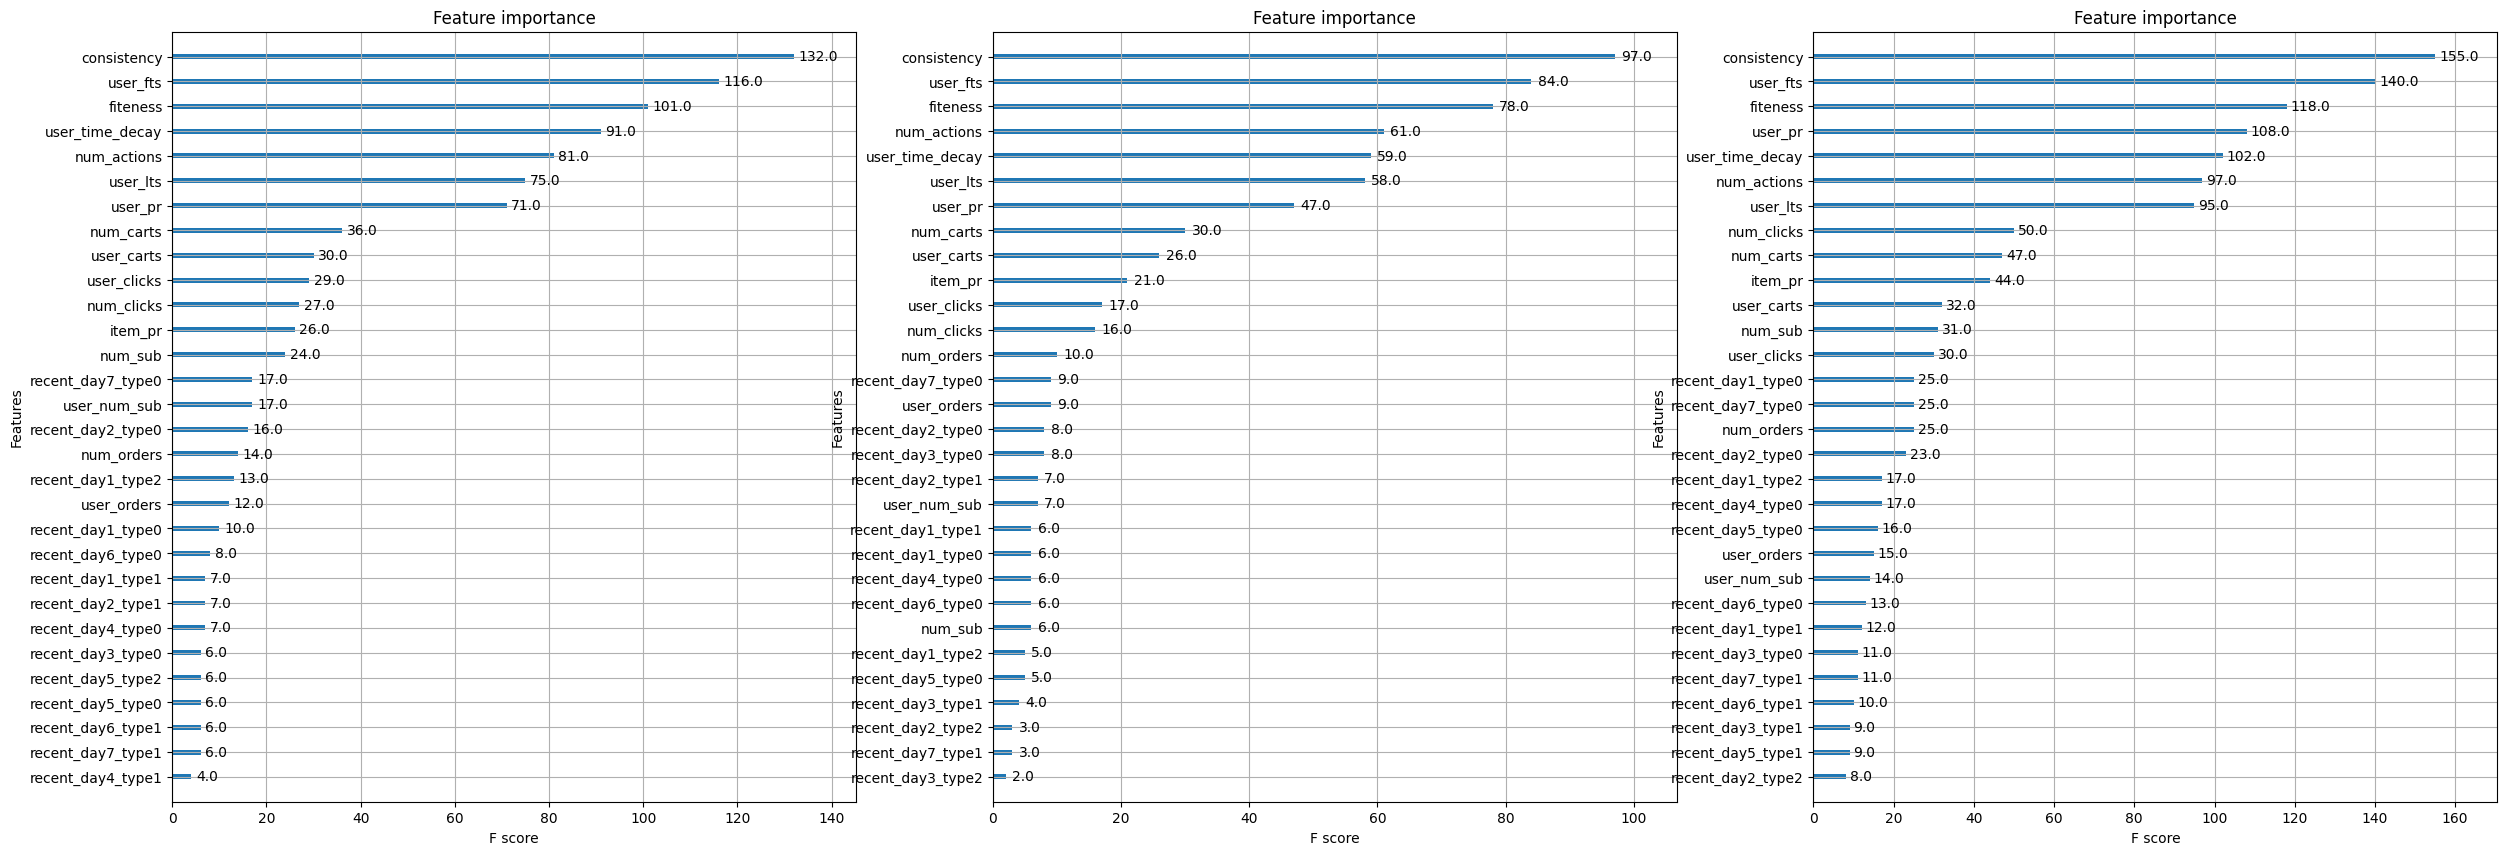

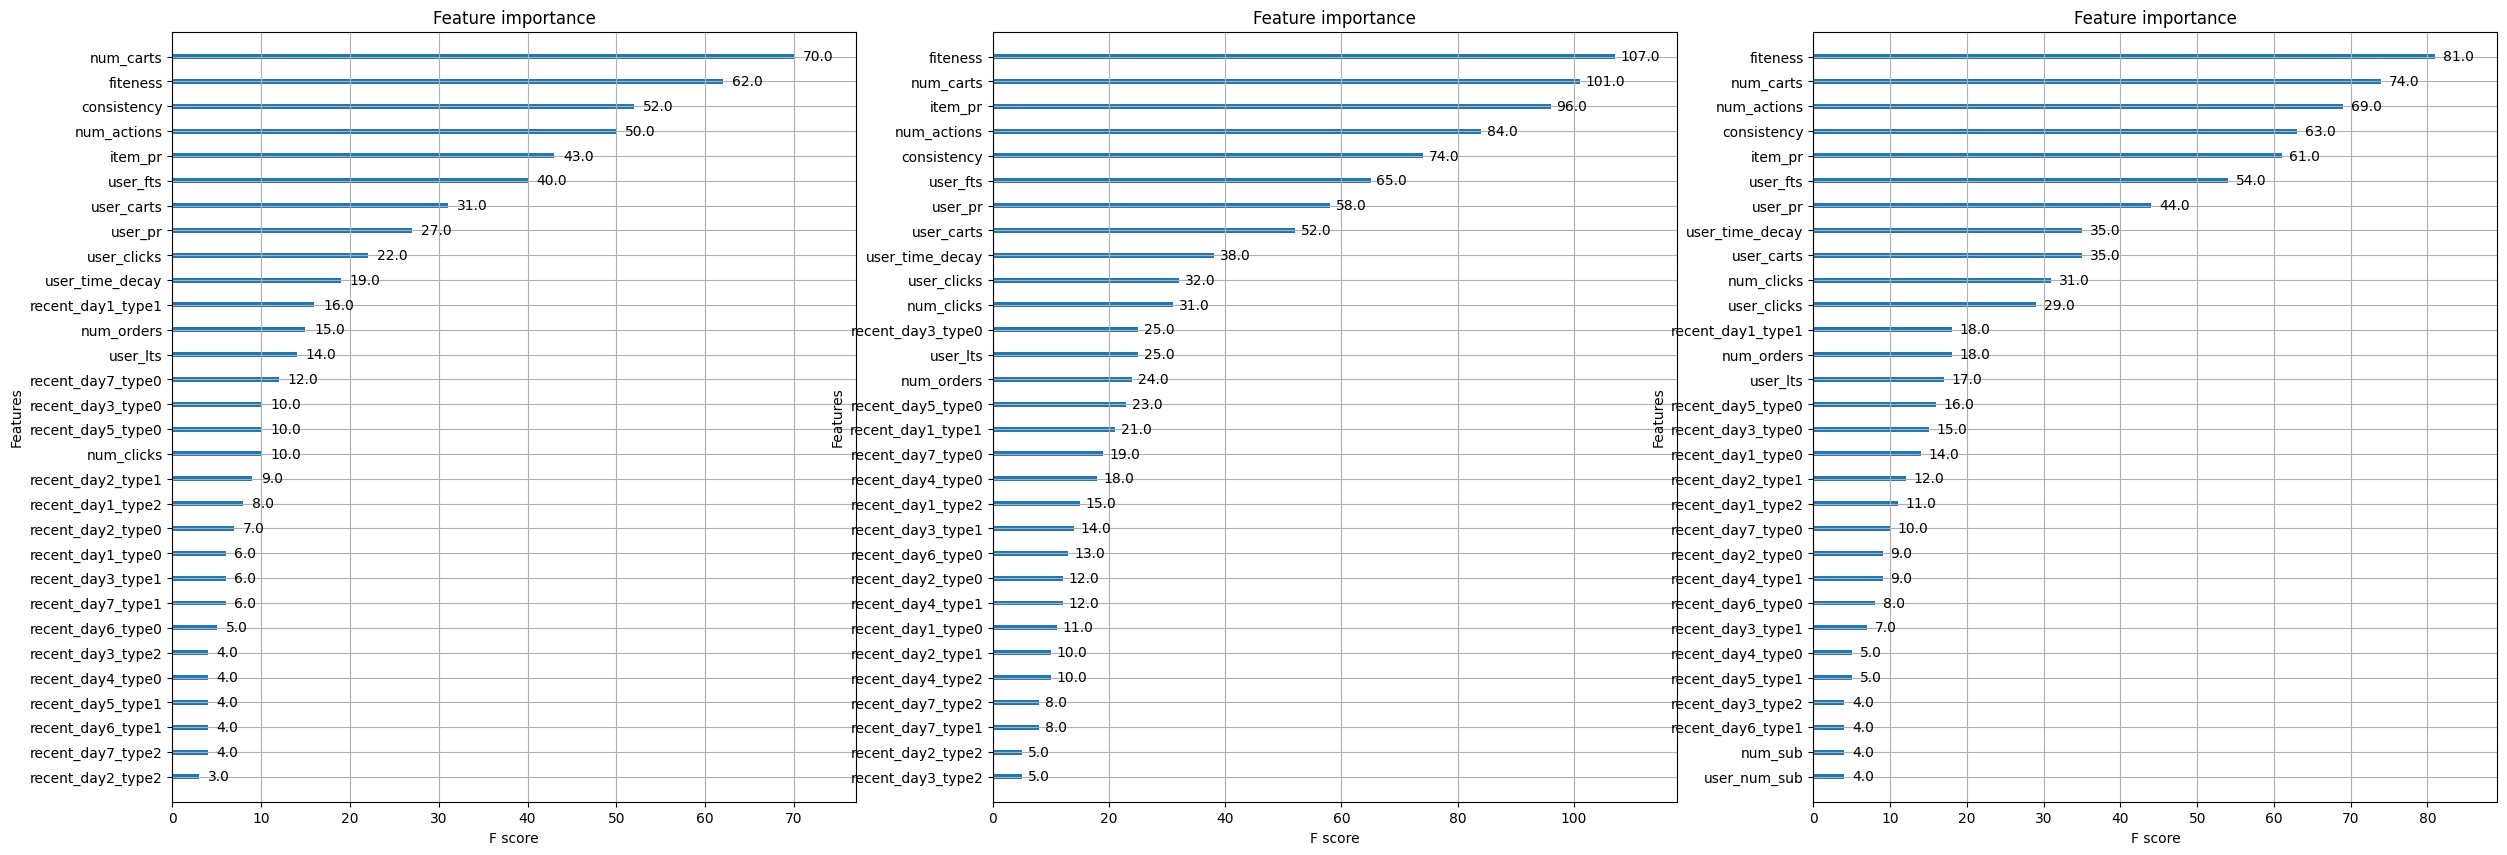

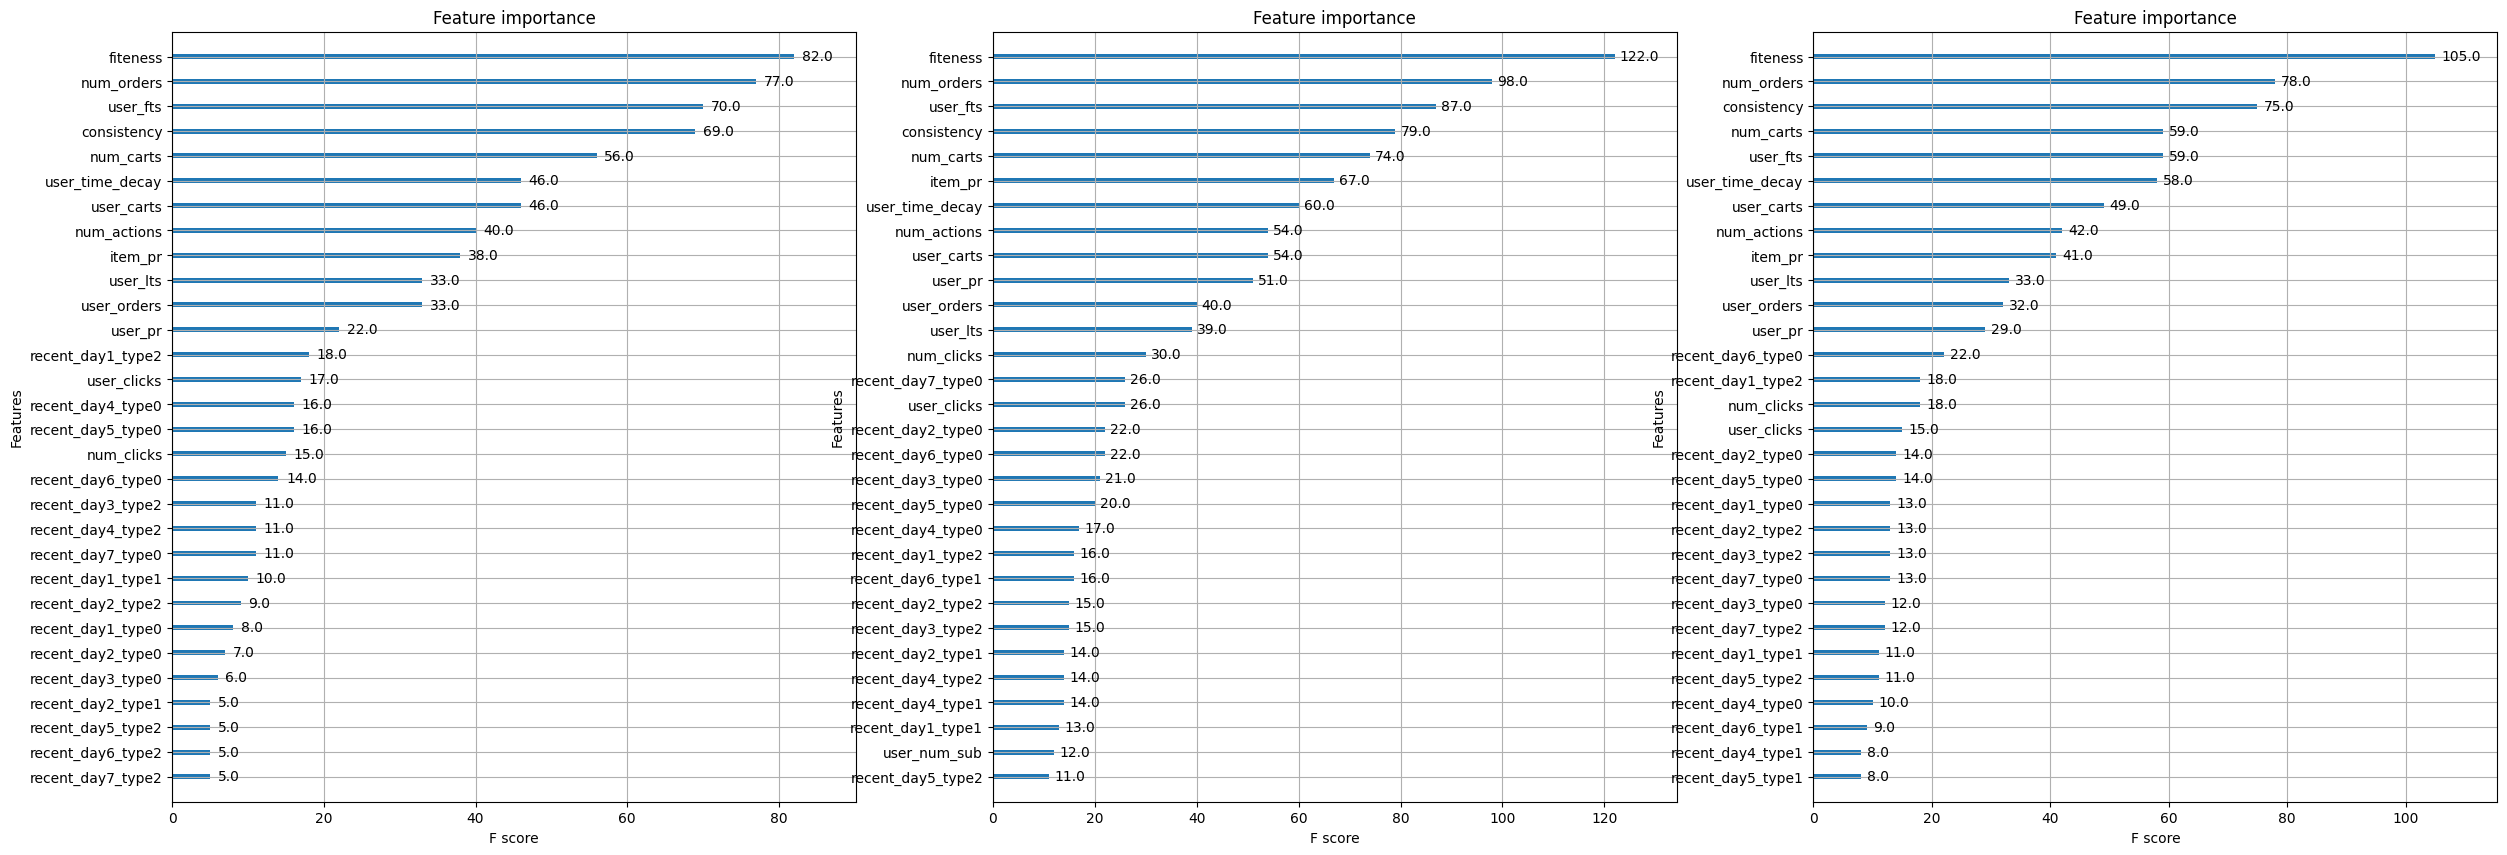

In [15]:
%%time
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, t, num_cands, id_type)